# Collaborative Recommendation Systems based on Item-Item Cosine Similarity Matrix

Outline
- Loading movies, users and ratings files
- Create movie vectors
- Compute  similarity matrix by calculating cosine similarity 
- Test Recommendations

In [1]:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from __future__ import print_function
import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow as tf
import altair as alt
import datapane as dp
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format

## Read users,ratings and movies files

In [4]:
input_file_path = '/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/data/processed/movieLense'
output_files = '/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/data/processed/outputs'

In [5]:
# Utility function to read files
def read_file(file_name):
    return pd.read_csv(open(f"{input_file_path}/{file_name}", 'r'))

In [6]:
# Utility function to Write files
def write_file(df,file_name):
    return df.to_csv(f"{output_files}/{file_name}", index=False)

In [7]:
import re

def remove_special_characters(text):
    '''Function to clean up any given text by removing non alphanumeric characters with spaces'''
    # Define a pattern to keep only alphanumeric characters
    pattern = re.compile(r'[^a-zA-Z0-9\s]')

    # Use the pattern to replace non-alphanumeric characters with an empty string
    cleaned_text = re.sub(pattern, '', text)

    return cleaned_text

### Users

In [8]:
users = read_file('users.csv')

In [9]:
users.head()

,id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


### Ratings

In [10]:
ratings = read_file('ratings_short.csv')

In [11]:
ratings.head()

,user_id,movie_id,imdb_id,rating
0,1,1,tt0114709,5
1,2,1,tt0114709,4
2,5,1,tt0114709,4
3,6,1,tt0114709,4
4,10,1,tt0114709,4


### Movies

In [12]:
movies = read_file('movies_combined.csv')

In [13]:
movies.head()

,ml_id,title,release_year,imdb_id,unknown,Action,Adventure,Animation,Children's,Comedy,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,plot_summary,crew
0,1,Toy Story,1995,tt0114709,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,Woody is a pull-string cowboy doll and leader ...,"[{""category"":""writer"",""crew_name"":""Joel Cohen""..."
1,2,GoldenEye,1995,tt0097446,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,NaN,"[{""category"":""composer"",""crew_name"":""Michael B..."
2,3,Four Rooms,1995,tt0113101,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,"The film is set on New Year's Eve, and starts ...","[{""category"":""producer"",""crew_name"":""Lawrence ..."
3,4,Get Shorty,1995,tt0113161,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,"Chili Palmer , a loan shark based in Miami, cl...","[{""category"":""composer"",""crew_name"":""John Luri..."
4,5,Copycat,1995,tt0112722,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,After giving a guest lecture on criminal psych...,"[{""category"":""composer"",""crew_name"":""Christoph..."


In [14]:
movies['cleaned_title'] = movies['title'].apply(lambda x:x.lower()).apply(remove_special_characters).str.replace(" ","")

In [15]:
movies.head(3)

,ml_id,title,release_year,imdb_id,unknown,Action,Adventure,Animation,Children's,Comedy,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,plot_summary,crew,cleaned_title
0,1,Toy Story,1995,tt0114709,0,0,0,1,1,1,...,0,0,0,0,0,0,0,Woody is a pull-string cowboy doll and leader ...,"[{""category"":""writer"",""crew_name"":""Joel Cohen""...",toystory
1,2,GoldenEye,1995,tt0097446,0,1,1,0,0,0,...,0,0,0,0,1,0,0,NaN,"[{""category"":""composer"",""crew_name"":""Michael B...",goldeneye
2,3,Four Rooms,1995,tt0113101,0,0,0,0,0,0,...,0,0,0,0,1,0,0,"The film is set on New Year's Eve, and starts ...","[{""category"":""producer"",""crew_name"":""Lawrence ...",fourrooms


### Basic checks

In [16]:
# Check for the shape of each users, item(movies) and ratings
users.shape
ratings.shape
movies.shape

(943, 5)

(99383, 4)

(1663, 26)

In [17]:
# Check for duplications
users.duplicated().sum()
ratings.duplicated().sum()
movies.duplicated().sum()

0

0

0

## Concept
- Item-Item Similarity Matrix
    - For item-based collaborative filtering, an item-item similarity matrix is created. 
    - This matrix measures the similarity between items based on how users have rated them.
- We want to create a movie vector matrix representing user ratings

|    |user1|user2|user3|user4|...|user943|
|----|-----|-----|-----|-----|---|-------|
|movie1|5|2|0|1|...|3|
|movie2|0|4|1|3|...|1|
|movie3|3|2|1|5|...|0|
|movie1663|3|2|1|5|...|0|

- We will then find the distance of each movie from other movies using cosine similarity 
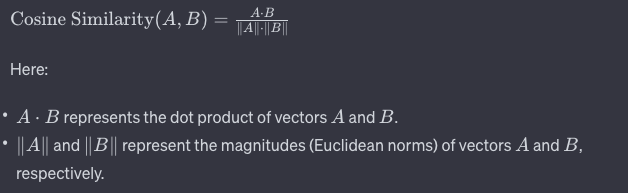

- In the context of item-item similarity in recommendation systems:

    -  Each item corresponds to a vector representing user ratings.
    -  The dot product of two item vectors measures the similarity in terms of user preferences.
    -  The magnitude of each item vector represents the "length" of the preferences.
        - The length of the preference vector reflects the strength or intensity of the preferences. 
        - Larger magnitudes indicate a stronger preference, while smaller magnitudes suggest weaker preferences.
    -  When calculating cosine similarity, the length of the preference vectors is used to normalize the dot product, ensuring that the similarity score is not biased by the overall intensity of preferences. 
    - The normalization helps focus on the direction of preferences rather than their absolute magnitudes.

In [18]:
# Check the number of ratings given by each user
ratings.groupby('user_id').count()['rating']

user_id
1      270
2       61
3       51
4       23
5      174
      ... 
939     48
940    107
941     22
942     77
943    168
Name: rating, Length: 943, dtype: int64

In [19]:
# Lets check the minimum number of movies rated
ratings.groupby('user_id').count()['rating'].min()

19

In [20]:
# Check the number of ratings given for each movie
ratings.groupby('movie_id').count()['rating']

movie_id
1       452
2       131
3        90
4       209
5        86
       ... 
1677      1
1678      1
1679      1
1681      1
1682      1
Name: rating, Length: 1663, dtype: int64

In [21]:
ratings.shape

(99383, 4)

## Create movie vectors

In [22]:
# Pivot the ratings table to get movie vectors
ratings_pt = ratings.pivot_table(index='imdb_id',columns='user_id',values='rating')

In [23]:
ratings_pt

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0000001,3.000,3.000,NaN,NaN,1.000,3.000,4.000,NaN,5.000,4.000,...,3.000,NaN,4.000,NaN,4.000,5.000,3.000,5.000,NaN,4.000
tt0000007,NaN,NaN,NaN,NaN,4.000,3.000,5.000,NaN,NaN,NaN,...,3.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000,3.000
tt0000012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.000,NaN,NaN,NaN,NaN,NaN,NaN,3.000
tt0000038,NaN,NaN,2.000,NaN,NaN,NaN,NaN,NaN,NaN,4.000,...,NaN,NaN,3.000,NaN,4.000,NaN,NaN,NaN,NaN,NaN
tt0000095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt4440776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tt5276348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tt5494894,NaN,NaN,NaN,NaN,NaN,NaN,4.000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# fillna values with 0
ratings_pt.fillna(0,inplace=True)

In [25]:
ratings_pt.head(5)

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0000001,3.000,3.000,0.000,0.000,1.000,3.000,4.000,0.000,5.000,4.000,...,3.000,0.000,4.000,0.000,4.000,5.000,3.000,5.000,0.000,4.000
tt0000007,0.000,0.000,0.000,0.000,4.000,3.000,5.000,0.000,0.000,0.000,...,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,3.000
tt0000012,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000
tt0000038,0.000,0.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,...,0.000,0.000,3.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000
tt0000095,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000


In [26]:
ratings_pt.shape

(1635, 943)

## Compute cosine similarity score

In [27]:
from sklearn.metrics.pairwise import cosine_similarity

In [28]:
# Calculate the cosine similarity of each movie against all movies
# The values in the matrix represent the similarity between items. Again, diagonal elements are usually set to 1
similarity = cosine_similarity(ratings_pt)

In [29]:
similarity.shape

(1635, 1635)

In [30]:
#Check for an index values for cosine similarity score
similarity[1239]

array([0.33000055, 0.30813189, 0.17502279, ..., 0.10995936, 0.        ,
       0.06555909])

In [31]:
# enumerate helps to retain the original indext values
sorted(list(enumerate(similarity[0])),reverse=True,key=lambda x:x[1])[1:6]

[(608, 0.6605234120008394),
 (667, 0.640113344574141),
 (650, 0.6054834037970568),
 (586, 0.6022327078155161),
 (53, 0.5960021099971947)]

In [32]:
ratings_pt_indexes = list(enumerate(ratings_pt.index))

## Test recommendations
Predictions are made by considering the preferences for similar items

In [33]:
# Search for the value in the list of tuples
def find_index(movie):
    '''
    Function to identify the index of a given movie
    '''
    search_value = movies[movies['cleaned_title'].isin([movie])]['imdb_id'].values[0]
    print(search_value)
    found_tuples = [tup for tup in ratings_pt_indexes if search_value in tup]

    # Display the result
    if found_tuples:
        print(f"Found tuples containing '{search_value}':")
        for found_tuple in found_tuples:
            print(found_tuple)
            print (found_tuple[0])
        return found_tuple[0]
    else:
        print(f"No tuples containing '{search_value}' found.")

In [34]:
def recommend_based_on_title(movie):
    '''Function to recommend movies based on title '''
    # Clean the input movie title
    cleaned_movie = remove_special_characters(movie.lower().strip()).replace(" ","")
    # Search the title in the new dataframe
    try:
        index = find_index(cleaned_movie)
        print(index)
        # Get the cosine distance of this movie with respect to other movies from similarity matrix computed above
        distances = similarity[index]
        print(distances)
        # Sort the distances in ascending order and select first 5 movies closet to the movies
        similar_items = sorted(list(enumerate(distances)),reverse=True,key=lambda x:x[1])[1:6]
        movies=[]
        for i in similar_items:
            movies.append(ratings_pt.index[i[0]])
        return movies
    except:
        print("Movie not found in DB - " + movie)
        return None

In [35]:
movie_list=recommend_based_on_title('Toy Story')
movie_list.append('tt0114709')
recom=movies[movies['imdb_id'].isin(movie_list)]

tt0114709
Found tuples containing 'tt0114709':
(1221, 'tt0114709')
1221
1221
[0.59029762 0.55580834 0.30220277 ... 0.1215361  0.06330273 0.0250226 ]


In [36]:
recom

,ml_id,title,release_year,imdb_id,unknown,Action,Adventure,Animation,Children's,Comedy,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,plot_summary,crew,cleaned_title
0,1,Toy Story,1995,tt0114709,0,0,0,1,1,1,...,0,0,0,0,0,0,0,Woody is a pull-string cowboy doll and leader ...,"[{""category"":""writer"",""crew_name"":""Joel Cohen""...",toystory
49,50,Star Wars,1977,tt0076759,0,1,1,0,0,0,...,0,0,1,1,0,1,0,NaN,"[{""category"":""editor"",""crew_name"":""Richard Che...",starwars
116,117,"Rock, The",1996,tt0004436,0,1,1,0,0,0,...,0,0,0,0,1,0,0,NaN,"[{""category"":""actress"",""crew_name"":""Helen Holm...",rockthe
120,121,Independence Day,1996,tt0073165,0,1,0,0,0,0,...,0,0,0,1,0,1,0,NaN,"[{""category"":""actor"",""crew_name"":""Mel Rosier""}...",independenceday
180,181,Return of the Jedi,1997,tt0086190,0,1,1,0,0,0,...,0,0,1,1,0,1,0,NaN,"[{""category"":""composer"",""crew_name"":""John Will...",returnofthejedi
400,405,Mission: Impossible,1996,tt0060009,0,1,1,0,0,0,...,0,1,0,0,0,0,0,NaN,"[{""category"":""actress"",""crew_name"":""Lesley Ann...",missionimpossible


In [37]:
recom_ratings=ratings[ratings['imdb_id'].isin(movie_list)]
recom_ratings.sort_values(by='user_id')

,user_id,movie_id,imdb_id,rating
0,1,1,tt0114709,5
15960,1,117,tt0004436,3
16702,1,121,tt0073165,4
6402,1,50,tt0076759,5
26164,1,181,tt0086190,5
...,...,...,...,...
17130,943,121,tt0073165,3
6984,943,50,tt0076759,4
16337,943,117,tt0004436,4
26670,943,181,tt0086190,4


In [38]:
m_list = []
for index,row in recom.iterrows():
    new_list = {'imdb_id': row['imdb_id'],
                'title': row['title']}
    m_list.append(new_list)
print(m_list)

[{'imdb_id': 'tt0114709', 'title': 'Toy Story '}, {'imdb_id': 'tt0076759', 'title': 'Star Wars '}, {'imdb_id': 'tt0004436', 'title': 'Rock, The '}, {'imdb_id': 'tt0073165', 'title': 'Independence Day '}, {'imdb_id': 'tt0086190', 'title': 'Return of the Jedi '}, {'imdb_id': 'tt0060009', 'title': 'Mission: Impossible '}]


In [39]:
movie_list

['tt0076759', 'tt0086190', 'tt0073165', 'tt0004436', 'tt0060009', 'tt0114709']

## Save Models

In [40]:
import pickle
pickle.dump(similarity,open('/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/models/collab_filtering_item_item_similarity/collab_similarity.pkl','wb'))

In [41]:
pickle.dump(ratings_pt_indexes,open('/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/models/collab_filtering_item_item_similarity/collab_ratings_pt_indexes.pkl','wb'))

In [42]:
pickle.dump(ratings_pt,open('/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/models/collab_filtering_item_item_similarity/collab_ratings_pt.pkl','wb'))

In [43]:
movies.to_csv('/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/data/processed/movieLense/movies_combined_cleaned_title.csv', index=False)